In [ ]:
from google.colab import drive
drive.mount("/content/drive")

from zipfile import ZipFile
data_path = "/content/drive/My Drive/dog-breed-identification.zip"

with ZipFile(data_path, 'r') as zip:
  zip.extractall()
  print("The dataset has been extracted")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The dataset has been extracted


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import cv2
import tensorflow as tf
import keras
from keras import layers
from functools import partial

import warnings
warnings.filterwarnings('ignore')
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
df = pd.read_csv('labels.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
df.shape

(10222, 2)

In [ ]:
df['breed'].unique()

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound',
       'shetland_sheepdog', 'walker_hound', 'maltese_dog',
       'norfolk_terrier', 'african_hunting_dog',
       'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer',
       'doberman', 'otterhound', 'standard_schnauzer',
       'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn',
       'affenpinscher', 'labrador_retriever', 'ibizan_hound',
       'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael',
       'dhole', 'toy_poodle', 'border_terrier', 'tibetan_terrier',
       'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz',
       'german_shepherd', 'greater_swiss_mountain_dog', 'basset',
       'australian_terrier', 'schipperke', 'rhodesian_ridgeback',
       'irish_setter', 'appenzeller', 'bloodhound', 'samoyed',
       'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon',
       'borde

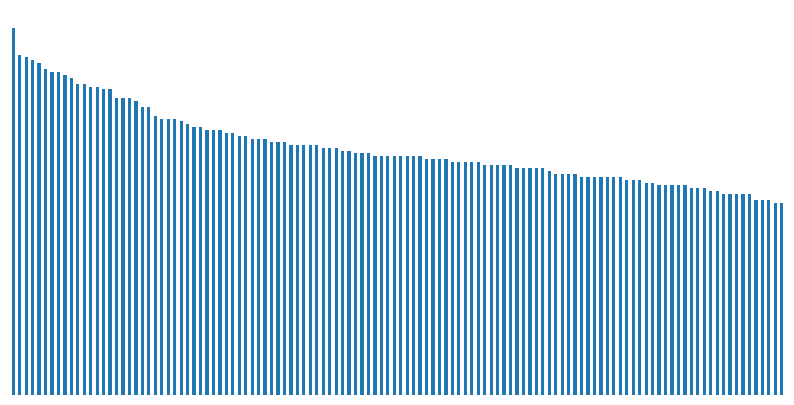

In [ ]:
plt.figure(figsize=(10, 5))
df['breed'].value_counts().plot.bar()
plt.axis('off')
plt.show()

In [ ]:
df['filepath'] = 'train/' + df['id'] + '.jpg'
df.head()

,id,breed,filepath
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


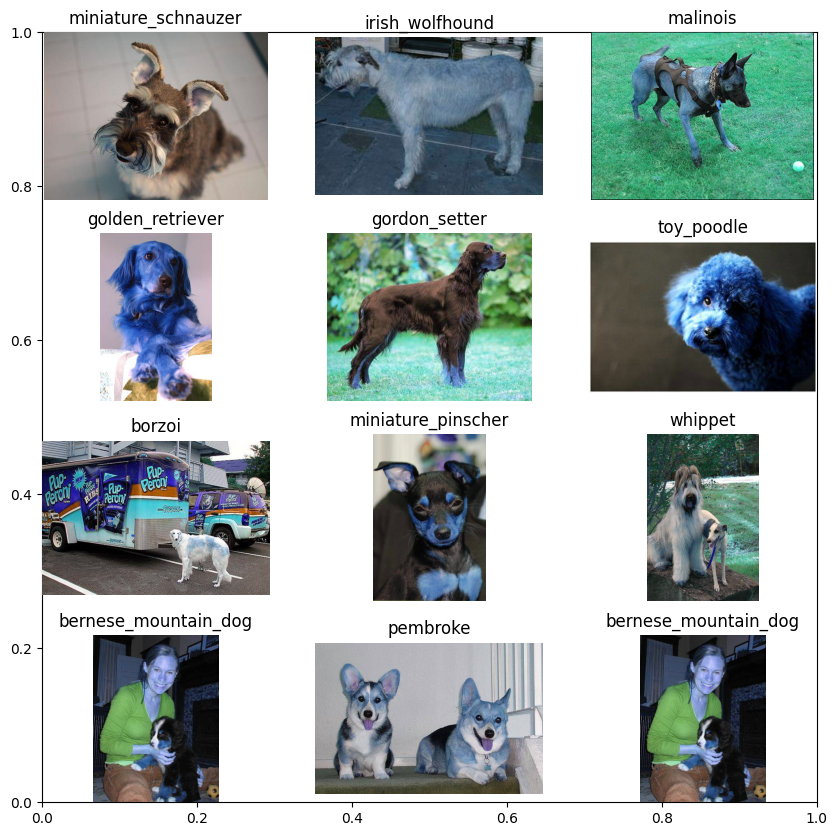

In [ ]:
plt.subplots(figsize=(10, 10))
for i in range(12):
  plt.subplot(4, 3, i+1)

  k = np.random.randint(0 , len(df))
  img = cv2.imread(df.loc[k, 'filepath'])
  plt.imshow(img)
  plt.title(df.loc[k, 'breed'])
  plt.axis('off')
plt.show()

In [ ]:
le = LabelEncoder()
df['breed'] = le.fit_transform(df['breed'])
df.head()

,id,breed,filepath
0,000bec180eb18c7604dcecc8fe0dba07,19,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,37,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,85,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,15,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,49,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


In [ ]:
features = df['filepath']
target = df['breed']

X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.15, random_state=10)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((8688,), (1534,), (8688,), (1534,))

In [ ]:
import albumentations as A

transform_train = A.Compose([
    A.VerticalFlip(p=0.2),
    A.HorizontalFlip(p=0.7),
    A.CoarseDropout(p=0.5),
    A.RandomGamma(p=0.5),
    A.RandomBrightnessContrast(p=1)
])

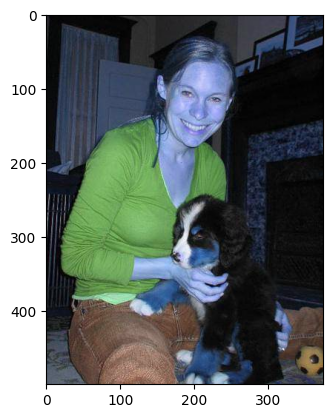

In [ ]:
img = cv2.imread(df.loc[k, 'filepath'])
plt.imshow(img)
plt.show()

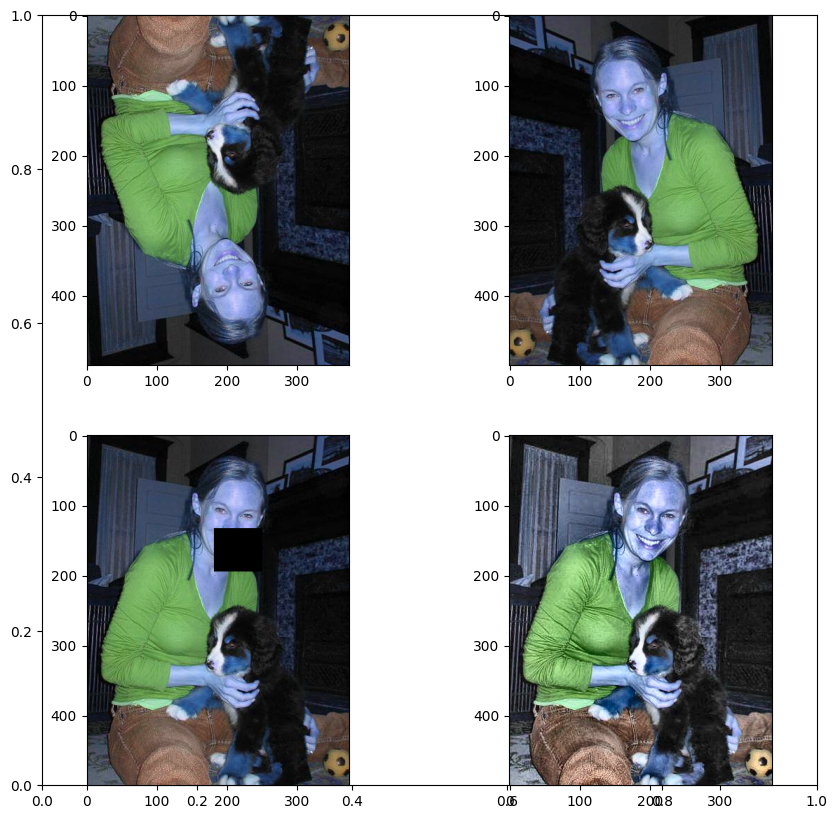

In [ ]:
augments = [A.VerticalFlip(p=1), A.HorizontalFlip(p=1), A.CoarseDropout(p=1), A.CLAHE(p=1)]

plt.subplots(figsize=(10, 10))
for i, aug in enumerate(augments):
  plt.subplot(2, 2, i+1)
  aug_img = aug(image=img)['image']
  plt.imshow(aug_img)
plt.show()

In [ ]:
def aug_fn(img):
  aug_data = transform_train(image=img)
  aug_img = aug_data['image']

  return aug_img

@tf.function
def process_data(img, label):
  aug_img = tf.numpy_function(aug_fn, [img], Tout=tf.float32)

  return img, label

def decode_image(filepath, label=None):
  img = tf.io.read_file(filepath)
  img = tf.image.decode_jpeg(img)
  img = tf.image.resize(img, [128,128])
  img = tf.cast(img, tf.float32) / 255.0

  if label == None:
    return img

  return img, tf.one_hot(indices=label, depth=120, dtype=tf.float32)

In [ ]:
train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train, Y_train))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(partial(process_data), num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

val_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_val, Y_val))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

In [ ]:
for img, label in train_ds.take(1):
  print(img.shape, label.shape)

(32, 128, 128, 3) (32, 120)


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
    input_shape=(128,128,3),
    weights='imagenet',
    include_top=False
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
print(len(pre_trained_model.layers))

311


In [ ]:
for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
print(f"last layer output shape: {last_layer.output.shape}")
last_output = last_layer.output

last layer output shape: (None, 6, 6, 768)


In [ ]:
x = layers.Flatten()(last_output)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(120, activation='softmax')(x)

model = keras.Model(pre_trained_model.input, output)

model.compile(
    optimizer='adam',
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.AUC()]
)

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_auc') is not None and logs.get('val_auc') > 0.99:
      print("\n Validation accuracy has reach upto 90% so, stopping further training")
      self.model.stop_training = True

es = EarlyStopping(patience=3,
                   monitor='val_auc',
                   restore_best_weights=True,
                   mode='max')

Ir = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

In [ ]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50,
                    verbose=1,
                    callbacks=[es, Ir, MyCallback()])

Epoch 1/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 247s 869ms/step - auc: 0.7202 - loss: 4.3425 - val_auc: 0.9375 - val_loss: 2.5700 - learning_rate: 0.0010
Epoch 2/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 242s 799ms/step - auc: 0.9634 - loss: 2.1861 - val_auc: 0.9383 - val_loss: 2.3631 - learning_rate: 0.0010
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 272s 837ms/step - auc: 0.9914 - loss: 1.1774 - val_auc: 0.9211 - val_loss: 2.4850 - learning_rate: 0.0010
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - auc: 0.9987 - loss: 0.4921
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
272/272 ━━━━━━━━━━━━━━━━━━━━ 222s 816ms/step - auc: 0.9987 - loss: 0.4918 - val_auc: 0.9130 - val_loss: 2.4970 - learning_rate: 0.0010
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 269s 841ms/step - auc: 0.9999 - loss: 0.1728 - val_auc: 0.9255 - val_loss: 2.3489 - learning_rate: 5.0000e-04


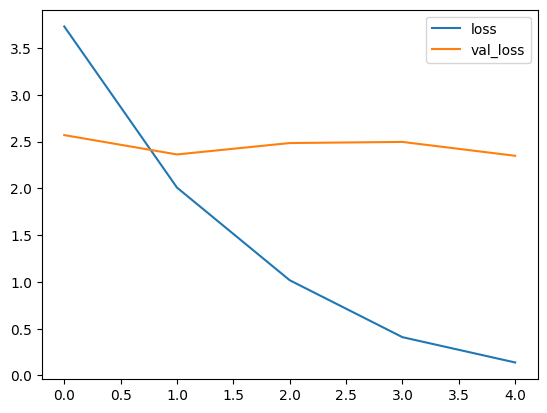

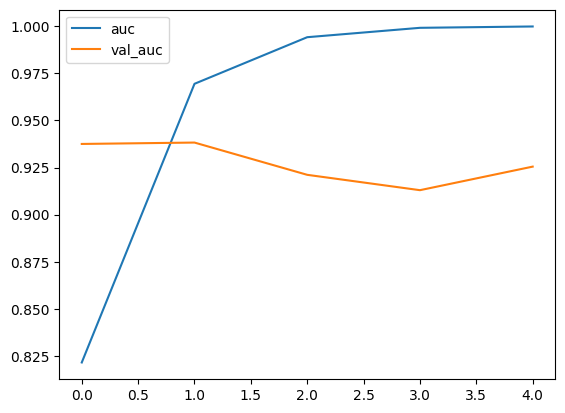

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['auc', 'val_auc']].plot()
plt.show()

##Modify_file